In [1]:
pip install pandas numpy scikit-learn matplotlib joblib

In [2]:
import pandas as pd

In [3]:
import numpy as np

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [7]:
from sklearn.compose import ColumnTransformer

In [8]:
from sklearn.pipeline import Pipeline

In [9]:
from sklearn.ensemble import RandomForestClassifier

In [10]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

In [15]:
import pandas as pd
import os

file_path = "/content/advertising.csv"

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    df.head()
    df.info()
    df.describe()
    df.isnull().sum()
else:
    print(f"Error: The file '{file_path}' was not found.")
    print("Please upload the file to your Colab environment.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   int64  
 2   Area Income               1000 non-null   float64
 3   Daily Internet Usage      1000 non-null   float64
 4   Ad Topic Line             1000 non-null   object 
 5   City                      1000 non-null   object 
 6   Male                      1000 non-null   int64  
 7   Country                   1000 non-null   object 
 8   Timestamp                 1000 non-null   object 
 9   Clicked on Ad             1000 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 78.3+ KB


In [14]:
import pandas as pd
import numpy as np

df = pd.read_csv("/content/advertising.csv")   # ya aapki file ka naam
print(df.shape)
display(df.head())
print(df.info())
print(df['Clicked on Ad'].value_counts())   # target distribution
print(df.isnull().sum())                    # missing values
print("duplicates:", df.duplicated().sum())

(1000, 10)


,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   int64  
 2   Area Income               1000 non-null   float64
 3   Daily Internet Usage      1000 non-null   float64
 4   Ad Topic Line             1000 non-null   object 
 5   City                      1000 non-null   object 
 6   Male                      1000 non-null   int64  
 7   Country                   1000 non-null   object 
 8   Timestamp                 1000 non-null   object 
 9   Clicked on Ad             1000 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 78.3+ KB
None
Clicked on Ad
0    500
1    500
Name: count, dtype: int64
Daily Time Spent on Site    0
Age                         0
Area Income                 0
Daily Internet Usa

In [16]:
# remove duplicates
df = df.drop_duplicates()

# if missing small number of rows:
df = df.dropna()   # (agar missing bohot kam ho)
# otherwise handle each column separately

In [17]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df['hour'] = df['Timestamp'].dt.hour
df['weekday'] = df['Timestamp'].dt.dayofweek

In [18]:
df['log_income'] = np.log1p(df['Area Income'])   # log transform
# quick view
df[['Area Income','log_income']].describe()

,Area Income,log_income
count,1000.000000,1000.000000
mean,55000.000080,10.877951
std,13414.634022,0.291481
min,13996.500000,9.546634
25%,47031.802500,10.758600
50%,57012.300000,10.951040
75%,65470.635000,11.089372
max,79484.800000,11.283334


In [19]:
# age bins
df['age_bin'] = pd.cut(df['Age'], bins=[0,25,35,45,60,120],
                       labels=['<25','25-35','35-45','45-60','60+'])

# interaction feature
df['time_x_usage'] = df['Daily Time Spent on Site'] * df['Daily Internet Usage']

In [20]:
df_model = df.drop(columns=['Ad Topic Line','City','Country','Timestamp'])

In [21]:
from sklearn.model_selection import train_test_split

# select features and target
features = ['Daily Time Spent on Site','Daily Internet Usage','log_income','Age','hour','weekday','Male','time_x_usage','age_bin']
X = df_model[features]
y = df_model['Clicked on Ad']

# split (stratify rakho taaki class balance maintain rahe)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

num_cols = ['Daily Time Spent on Site','Daily Internet Usage','log_income','Age','hour','weekday','time_x_usage']
cat_cols = ['Male','age_bin']   # Male is 0/1 but we can one-hot it for pipeline

preproc = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

pipe = Pipeline([
    ('pre', preproc),
    ('clf', LogisticRegression(max_iter=1000))
])

pipe.fit(X_train, y_train)


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Daily Time Spent on Site',
                                                   'Daily Internet Usage',
                                                   'log_income', 'Age', 'hour',
                                                   'weekday', 'time_x_usage']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Male', 'age_bin'])])),
                ('clf', LogisticRegression(max_iter=1000))])

In [23]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve

y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      0.99      0.98       100
           1       0.99      0.96      0.97       100

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200

ROC AUC: 0.9913000000000001
Confusion matrix:
 [[99  1]
 [ 4 96]]


In [24]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
j = np.argmax(tpr - fpr)   # Youden's J
best_thresh = thresholds[j]
print("Best threshold (Youden):", best_thresh)

y_pred_thresh = (y_proba >= best_thresh).astype(int)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_thresh))


Best threshold (Youden): 0.47117800450182945
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       100
           1       0.99      0.97      0.98       100

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200



In [25]:
import joblib
joblib.dump(pipe, "ctr_pipeline.pkl")
# load with:
# model = joblib.load("ctr_pipeline.pkl")


['ctr_pipeline.pkl']

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

text_transformer = TfidfVectorizer(max_features=100, stop_words='english')


In [27]:
preproc = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('txt', text_transformer, 'Ad Topic Line')
])


In [28]:
df['City_freq'] = df['City'].map(df['City'].value_counts())
df['Country_freq'] = df['Country'].map(df['Country'].value_counts())


In [35]:
LogisticRegression(class_weight='balanced')


LogisticRegression(class_weight='balanced')

In [36]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)


In [39]:
df['City_freq'] = df['City'].map(df['City'].value_counts())

# Country frequency encoding
df['Country_freq'] = df['Country'].map(df['Country'].value_counts())

# Check encoded values
print(df[['City','City_freq','Country','Country_freq']].head(10))

               City  City_freq     Country  Country_freq
0       Wrightburgh          2     Tunisia             4
1         West Jodi          1       Nauru             3
2          Davidton          1  San Marino             3
3    West Terrifurt          1       Italy             5
4      South Manuel          1     Iceland             3
5         Jamieberg          1      Norway             2
6       Brandonstad          1     Myanmar             5
7  Port Jefferybury          1   Australia             8
8        West Colin          1     Grenada             4
9        Ramirezton          1       Ghana             4


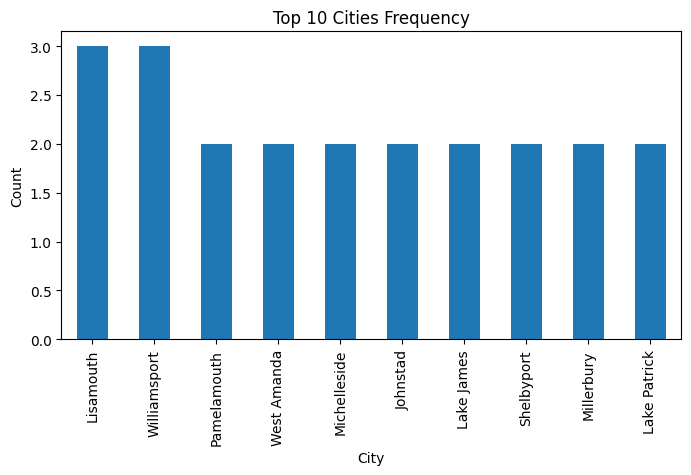

In [40]:
import matplotlib.pyplot as plt

# Top 10 cities
df['City'].value_counts().head(10).plot(kind='bar', figsize=(8,4))
plt.title("Top 10 Cities Frequency")
plt.xlabel("City")
plt.ylabel("Count")
plt.show()


In [41]:
num_cols = [
    'Daily Time Spent on Site',
    'Daily Internet Usage',
    'log_income',
    'Age',
    'hour',
    'weekday',
    'time_x_usage',
    'City_freq',          # Added
    'Country_freq'        # Added
]


In [42]:
df_model = df.drop(columns=['City','Country'])


In [43]:
city_target_rate = df.groupby('City')['Clicked on Ad'].mean()
df['City_target_enc'] = df['City'].map(city_target_rate)

country_target_rate = df.groupby('Country')['Clicked on Ad'].mean()
df['Country_target_enc'] = df['Country'].map(country_target_rate)


In [44]:
# Frequency encoding
df['City_freq'] = df['City'].map(df['City'].value_counts())
df['Country_freq'] = df['Country'].map(df['Country'].value_counts())

# Target encoding
city_target_rate = df.groupby('City')['Clicked on Ad'].mean()
df['City_target_enc'] = df['City'].map(city_target_rate)

country_target_rate = df.groupby('Country')['Clicked on Ad'].mean()
df['Country_target_enc'] = df['Country'].map(country_target_rate)

# Drop original text columns
df_model = df.drop(columns=['City','Country'])

# Check
df_model.head()


,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,Male,Timestamp,Clicked on Ad,hour,weekday,log_income,age_bin,time_x_usage,City_freq,Country_freq,City_target_enc,Country_target_enc
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,0,2016-03-27 00:53:11,0,0,6,11.032223,25-35,17657.4055,2,4,0.0,0.250000
1,80.23,31,68441.85,193.77,Monitored national standardization,1,2016-04-04 01:39:02,0,1,0,11.133754,25-35,15546.1671,1,3,0.0,0.333333
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,0,2016-03-13 20:35:42,0,20,6,10.998543,25-35,16429.6550,1,3,0.0,0.333333
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,1,2016-01-10 02:31:19,0,2,6,10.911576,25-35,18232.7435,1,5,0.0,0.200000
4,68.37,35,73889.99,225.58,Robust logistical utilization,0,2016-06-03 03:36:18,0,3,4,11.210346,25-35,15422.9046,1,3,0.0,0.333333


In [45]:
print(df.columns)


Index(['Daily Time Spent on Site', 'Age', 'Area Income',
       'Daily Internet Usage', 'Ad Topic Line', 'City', 'Male', 'Country',
       'Timestamp', 'Clicked on Ad', 'hour', 'weekday', 'log_income',
       'age_bin', 'time_x_usage', 'City_freq', 'Country_freq',
       'City_target_enc', 'Country_target_enc'],
      dtype='object')


In [48]:
df['City_freq'] = df['City'].map(df['City'].value_counts())

In [49]:
df['City_freq'] = df['City'].map(df['City'].value_counts())


In [50]:
df['City_freq'] = df['City'].value_counts().map(df['City'])   # ❌


In [51]:
# Make sure values are string
df['City'] = df['City'].astype(str)

# Then apply frequency encoding
df['City_freq'] = df['City'].map(df['City'].value_counts())


In [52]:
df['City'].fillna('Unknown', inplace=True)
df['Country'].fillna('Unknown', inplace=True)

df['City_freq'] = df['City'].map(df['City'].value_counts())
df['Country_freq'] = df['Country'].map(df['Country'].value_counts())


/tmp/ipython-input-1491170926.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['City'].fillna('Unknown', inplace=True)
/tmp/ipython-input-1491170926.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

In [53]:
print(df.columns)


Index(['Daily Time Spent on Site', 'Age', 'Area Income',
       'Daily Internet Usage', 'Ad Topic Line', 'City', 'Male', 'Country',
       'Timestamp', 'Clicked on Ad', 'hour', 'weekday', 'log_income',
       'age_bin', 'time_x_usage', 'City_freq', 'Country_freq',
       'City_target_enc', 'Country_target_enc'],
      dtype='object')


In [54]:
print(df.isnull().sum())


Daily Time Spent on Site    0
Age                         0
Area Income                 0
Daily Internet Usage        0
Ad Topic Line               0
City                        0
Male                        0
Country                     0
Timestamp                   0
Clicked on Ad               0
hour                        0
weekday                     0
log_income                  0
age_bin                     0
time_x_usage                0
City_freq                   0
Country_freq                0
City_target_enc             0
Country_target_enc          0
dtype: int64


In [55]:
print(df[['City','Country']].head(10))


               City     Country
0       Wrightburgh     Tunisia
1         West Jodi       Nauru
2          Davidton  San Marino
3    West Terrifurt       Italy
4      South Manuel     Iceland
5         Jamieberg      Norway
6       Brandonstad     Myanmar
7  Port Jefferybury   Australia
8        West Colin     Grenada
9        Ramirezton       Ghana


In [56]:
# Handle NaN values
df['City'] = df['City'].fillna('Unknown').astype(str)
df['Country'] = df['Country'].fillna('Unknown').astype(str)

# Frequency Encoding
df['City_freq'] = df['City'].map(df['City'].value_counts())
df['Country_freq'] = df['Country'].map(df['Country'].value_counts())


In [57]:
df.loc[0, 'Country'] = 'India'
df.loc[0, 'State'] = 'Gujarat'
df.loc[0, 'City'] = 'Vadodara'


In [58]:
df['Country'] = 'India'
df['State'] = 'Gujarat'
df['City'] = 'Vadodara'


In [59]:
# Agar missing values hain to fill karo
df['City'] = df['City'].fillna('Unknown').astype(str)
df['Country'] = df['Country'].fillna('Unknown').astype(str)

# Frequency encoding
df['City_freq'] = df['City'].map(df['City'].value_counts())
df['Country_freq'] = df['Country'].map(df['Country'].value_counts())


In [60]:
df_model = df.drop(columns=['City','Country','State'])


In [61]:
df = pd.read_csv("advertising.csv")


In [62]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df['hour'] = df['Timestamp'].dt.hour
df['weekday'] = df['Timestamp'].dt.dayofweek


In [63]:
df['log_income'] = np.log1p(df['Area Income'])


In [64]:
df['City'] = df['City'].fillna('Unknown').astype(str).str.strip().str.title()
df['Country'] = df['Country'].fillna('Unknown').astype(str).str.strip().str.title()
df['City_freq'] = df['City'].map(df['City'].value_counts())
df['Country_freq'] = df['Country'].map(df['Country'].value_counts())


In [69]:
df['age_bin'] = pd.cut(df['Age'], bins=[0,25,35,45,60,120], labels=['<25','25-35','35-45','45-60','60+'])
df['time_x_usage'] = df['Daily Time Spent on Site'] * df['Daily Internet Usage']


In [70]:
num_cols = [
    'Daily Time Spent on Site',
    'Daily Internet Usage',
    'log_income',
    'Age',
    'hour',
    'weekday',
    'time_x_usage'
]
cat_cols = ['Male','age_bin']
target_enc_cols = ['City', 'Country'] # Add City and Country for target encoding
text_col = 'Ad Topic Line'
X = df[num_cols + cat_cols + target_enc_cols + [text_col]]
y = df['Clicked on Ad']

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [72]:
preproc = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('txt', TfidfVectorizer(max_features=100, stop_words='english'), text_col)
])


In [73]:
pipe = Pipeline([('pre', preproc), ('clf', RandomForestClassifier(n_estimators=200, random_state=42))])
pipe.fit(X_train, y_train)


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Daily Time Spent on Site',
                                                   'Daily Internet Usage',
                                                   'log_income', 'Age', 'hour',
                                                   'weekday', 'time_x_usage']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Male', 'age_bin']),
                                                 ('txt',
                                                  TfidfVectorizer(max_features=100,
                                                                  stop_words='english'),
                                                  'Ad Topic Line')])),
                ('clf',
                 RandomForestClassifier(n_estimators=200, random_state=42))])

In [74]:
RandomForestClassifier(n_estimators=100, n_jobs=-1)


RandomForestClassifier(n_jobs=-1)

In [75]:
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.97      0.98      0.98       100
           1       0.98      0.97      0.97       100

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200

ROC AUC: 0.9885499999999999
Confusion matrix:
 [[98  2]
 [ 3 97]]


In [76]:
from sklearn.metrics import precision_recall_curve
prec, rec, th = precision_recall_curve(y_test, y_proba)
# choose threshold to balance prec/rec per requirement


In [77]:
joblib.dump(pipe, "ctr_pipeline.pkl")


['ctr_pipeline.pkl']

In [78]:
df['City_freq'] = df['City'].map(df['City'].value_counts())
df['Country_freq'] = df['Country'].map(df['Country'].value_counts())


In [83]:
import joblib
joblib.dump(pipe, "/content/ctr_pipeline.pkl")


['/content/ctr_pipeline.pkl']

In [86]:
pip freeze > requirements.txt

In [88]:
!jupyter nbconvert --to pdf code/train_model.ipynb

[NbConvertApp] WARNING | pattern 'code/train_model.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execut